# Metrics for ISAViT

In [1]:
from torch import Tensor
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, get_transform
from project.utils import collatev2, compute_statistics
import winsound
from project.model import ISAVIT
from torchvision.models import resnet18, ResNet18_Weights
from project.utils import memcheck

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
image_size = 300
patch_size = 16

config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=patch_size,
        dim_ff=1600
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 10,
    'loss': nn.BCEWithLogitsLoss(),
    # 'loss': nn.MSELoss(),
    'lr': 0.0001
}

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Load dataset

In [4]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 7)

In [5]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,target,has_microbleed_case,has_microbleed_slice,cohort,max_value
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,1,1,1,928.405273
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,1,1,1,928.405273
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,11,1,1,1,928.405273
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,12,1,1,1,928.405273
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,15,1,1,1,928.405273
...,...,...,...,...,...,...,...
359,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1,3,241.000000
360,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,26,1,1,3,241.000000
361,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,24,1,1,3,448.000000
362,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1,3,448.000000


### `DataLoader` Generator

In [6]:
def iqr(data, col):
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iqr = q3-q1
    new = data[(data[col] < (q3 + 1.5*iqr)) & (data[col] > (q1 - 1.5*iqr))]
    return new

In [7]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 batch_size,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None
                ):
    data = data[data.cohort == cohort]
    # data = iqr(data, 'max_value')
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.mri.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.mri.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.mri.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    train_loader = DataLoader(
        train_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )
    val_loader = DataLoader(
        val_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_loader, val_loader

In [8]:
tl, vl = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False,
    batch_size=1
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 7), (9, 7))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)



### Create Stage 1 Network

In [9]:
from project.model import Feeder, RPN, GCRPN

resize = get_transform(
    height=patch_size,
    width=patch_size,
    p=1.0,
    rpn_mode=False
)

feeder = Feeder(resize)
rpn = RPN(
    input_dim=512,
    output_dim=4,
    image_size=image_size,
    nh=4,
)

stone = GCRPN(
    rpn=rpn,
    feeder=feeder,
    image_size=image_size,
    patch_size=patch_size
).to(device)

324


c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [10]:
stone.rpn.load_state_dict(torch.load('RPN_test15_weights_Nov_02_2024_192506.pt'))
vit = config['model']

vit.load_state_dict(torch.load('test_weights/vit_test2_weights_031124120907.pt'))

<All keys matched successfully>

## Metrics

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from torchmetrics.functional.segmentation import generalized_dice_score

In [22]:
sample_tensor = torch.randint(0, 2, (4, 5, 16, 16))
print(sample_tensor.shape)

torch.Size([4, 5, 16, 16])


Source of the functions: https://medium.com/@nghihuynh_37300/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f

same precision and recall computation from https://labelyourdata.com/articles/object-detection-metrics

Meron din dice na metric from torchmetrics pero same lang naman ng score from the link above


In [23]:
def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

In [31]:
iou_scores = []
preds = []
truths = []
cases = []
targets = []
precision_scores = []
recall_scores = []
dice_scores = []
accuracy_scores = []
counter = 0

for batch in enumerate(tl):
    slices, masks, target, case = batch[1][0]
    slices = slices.squeeze(1).float().to(device)
    masks = masks.float().to(device)
    with torch.inference_mode():
        x, t = stone(slices, masks, target)
    
    x = x.flatten(2).to(device)
    t = t.flatten(2).to(device)
    y = vit(x, target)

    y = y.view(1, patch_size, patch_size).unsqueeze(1)
    t = t[target].view(1, patch_size, patch_size).unsqueeze(1)
    
    print('Dice from torchmetrics:', generalized_dice_score(y, t, num_classes=1, per_class=True))

    y = y.squeeze().detach().cpu().numpy()
    t = t.squeeze().detach().cpu().numpy()

    # f, a = plt.subplots(1, 2, figsize=(10, 4))

    # f.tight_layout()
    # ax1 = a.flat[0]
    # ax2 = a.flat[1]
    # ax1.set_title('Mask Prediction')
    # ax2.set_title('Mask Truth')

    # print(y.shape)
    # print(t.shape)
    # sns.heatmap((y > -0.2), ax=ax1, vmax=1)
    # sns.heatmap(t, ax=ax2, vmax=1)

    dice_score = dice_coef(y, t)
    precision_score = precision_score_(y, t)
    recall_score = recall_score_(y, t)
    accuracy_score = accuracy(y, t)
    iou_score = iou(y, t)

    print('Dice from medium:', dice_coef(y, t))
    print('Precision from medium:', precision_score_(y, t))
    print('Recall from medium:', recall_score_(y, t))
    print('Accuracy from medium:', accuracy(y, t))
    print('IOU from medium:', iou(y, t))
    print()

    iou_scores.append(iou_score)
    preds.append(y)
    truths.append(t)
    cases.append(case)
    targets.append(target)
    precision_scores.append(precision_score)
    recall_scores.append(recall_score)
    dice_scores.append(dice_score)
    accuracy_scores.append(accuracy_score)
    
    counter += 1


Dice from torchmetrics: tensor([[0.]], device='cuda:0', grad_fn=<WhereBackward0>)
Dice from medium: 0.0
Precision from medium: nan
Recall from medium: 0.0
Accuracy from medium: 0.0
IOU from medium: 0.0



C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_25416\3831126590.py:10: RuntimeWarning: invalid value encountered in scalar divide
  precision = np.mean(intersect/total_pixel_pred)


Dice from torchmetrics: tensor([[0.]], device='cuda:0', grad_fn=<WhereBackward0>)
Dice from medium: 0.0
Precision from medium: nan
Recall from medium: 0.0
Accuracy from medium: 0.0
IOU from medium: 0.0

Dice from torchmetrics: tensor([[0.]], device='cuda:0', grad_fn=<WhereBackward0>)
Dice from medium: 0.0
Precision from medium: nan
Recall from medium: 0.0
Accuracy from medium: 0.0
IOU from medium: 0.0

Dice from torchmetrics: tensor([[0.0046]], device='cuda:0', grad_fn=<WhereBackward0>)
Dice from medium: 0.005
Precision from medium: -0.711
Recall from medium: 0.002
Accuracy from medium: 0.0
IOU from medium: 0.002

Dice from torchmetrics: tensor([[0.]], device='cuda:0', grad_fn=<WhereBackward0>)
Dice from medium: 0.0
Precision from medium: nan
Recall from medium: 0.0
Accuracy from medium: 0.0
IOU from medium: 0.0

Dice from torchmetrics: tensor([[0.]], device='cuda:0', grad_fn=<WhereBackward0>)
Dice from medium: 0.0
Precision from medium: nan
Recall from medium: 0.0
Accuracy from medium

In [32]:
def avg(scores):
    return sum(scores) / len(scores)

In [33]:
print(round(avg(iou_scores), 3))
print(round(avg(precision_scores), 3))
print(round(avg(recall_scores), 3))
print(round(avg(dice_scores), 3))
print(round(avg(accuracy_scores), 3))

0.003
nan
0.003
0.005
0.0


10
0.042
0.022


<Axes: title={'center': 'Mask Truth'}>

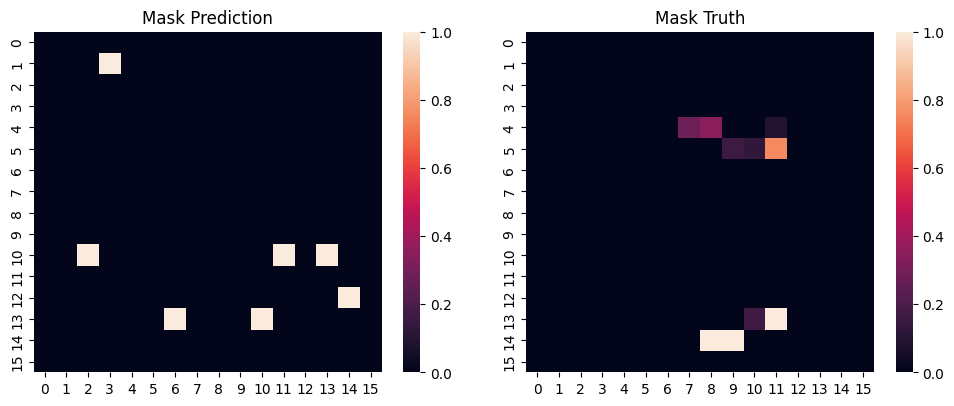

In [34]:
num = dice_scores.index(max(dice_scores))
print(num)

f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('Mask Prediction')
ax2.set_title('Mask Truth')

pred = preds[num]
truth = truths[num]

print(dice_scores[num])
print(iou_scores[num])

sns.heatmap((pred > -0.2), ax=ax1, vmax=1)
sns.heatmap(truth, ax=ax2, vmax=1)